<div style="text-align:center; margin-top: 1cm;">
    <h2>Київський політехнічний інститут імені Ігоря Сікорського</h2>
    <h2>Приладобудівний факультет</h2>
    <h3>Кафедра автоматизації та систем неруйнівного контролю</h3>
    <br><br><br>
</div>

<div style="text-align:center; margin-top: 5cm;">
    <h2>Практична робота №2 </h2>
    <h2>з предмету "Комп'ютерний зір"</h2>
</div>

<div style="text-align:right; margin-top: 5cm;">
<p>Студент: Погорєлов Богдан<br>
    Група: ПК-51мп<br>
</p>
</div>
<div style="text-align:center; margin-top: 5cm;">
2025 рік  <br><br><br><br>
</div>

Тема: Сегментація зображень та виділення контурів

Мета роботи:
Вивчення методів порогової обробки зображень (бінаризації) та алгоритмів виділення контурів (Sobel, DoG, Canny).

Розробити програму, яка виконує такі дії з ЦЗ:
1. В зоні вказаної геометричної форми виконати порогову обробку. Порогове значення вибрати самостійно
так, щоб найкращім чином виділити об’єкти. Порівняти це значення з значенням, розрахованим при
застосуванні порогової обробки за методом Отсу. Результат порогової обробки вставити в вхідне ЦЗ в зоні
заданої геометричної форми. Площа цієї зони повинна перевищувати 50 % від площі цифрового
зображення. Геометрична форма цієї зони визначається по варіантам згідно Таблиці 1.
2. У ЦЗ виділити контури об’єктів за допомогою цифрових фільтрів Собеля та DoG (різниця гаусових функцій)
та порогової обробки. Порівняти результати роботи детектора контурів Сanny з вказаною вище
попередньою обробкою та без неї. 

Таблиця 1. Варіанти практичного завдання № 1, 2.

| Тип функції | лемніската Бернуллі | фігура Ліссажу | епіциклоїда | гіпоциклоїда | кардіоїда |
| :--- | :---: | :---: | :---: | :---: | :---: |
| **гармонічна** | 1 | 2 | 3 | 4 | 5 |
| **лінійна** | 6 | 7 | 8 | 9 | 10 |
| **гаусоїда** | 11 | 12 | 13 | 14 | 15 |
| **логарифмічна** | 16 | 17 | 18 | 19 | 20 |
| **кубічна** | 21 | 22 | 23 | 24 | 25 |

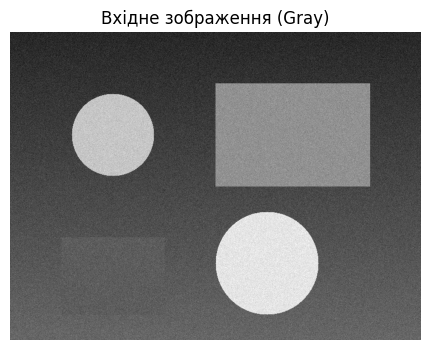

In [1]:
# 1. Підготовка зображення та функції генерації маски
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Генерація тестового зображення з об'єктами (якщо не завантажено файл)
def create_test_image():
    img = np.zeros((600, 800), dtype=np.uint8)
    # Фон (градієнт)
    for i in range(600):
        img[i, :] = 50 + i * 0.1
    
    # Додавання об'єктів (кола, прямокутники)
    cv2.circle(img, (200, 200), 80, 200, -1)
    cv2.rectangle(img, (400, 100), (700, 300), 150, -1)
    cv2.circle(img, (500, 450), 100, 230, -1)
    cv2.rectangle(img, (100, 400), (300, 550), 100, -1)
    
    # Додамо трохи шуму
    noise = np.random.normal(0, 10, img.shape).astype(np.int16)
    img_noisy = np.clip(img + noise, 0, 255).astype(np.uint8)
    return img_noisy

# Функція маски Ліссажу (з попереднього завдання)
def create_lissajous_mask(shape, center, size, params):
    h, w = shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)
    cx, cy = center
    rx, ry = size
    a, b, delta = params
    t = np.linspace(0, 2 * np.pi, 2000) # Більше точок для плавності великої фігури
    x = cx + rx * np.sin(a * t + delta)
    y = cy + ry * np.sin(b * t)
    points = np.stack((x, y), axis=1).astype(np.int32)
    cv2.fillPoly(mask, [points], 255)
    return mask

gray_image = create_test_image()

plt.figure(figsize=(6, 4))
plt.imshow(gray_image, cmap='gray')
plt.title("Вхідне зображення (Gray)")
plt.axis('off')
plt.show()

Площа зони складає: 46.41% від усього зображення
Ручний поріг: 127
Розрахований поріг Отсу: 131.0


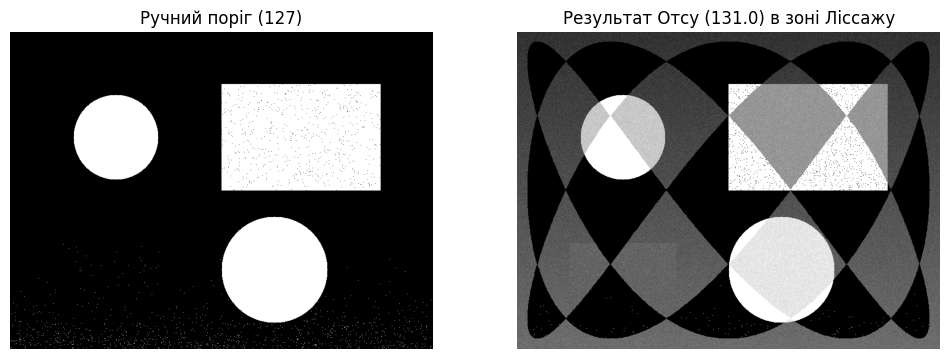

In [ ]:
# 2. Завдання 1: Порогова обробка в зоні Ліссажу
# 1. Створення маски великої площі (>50%)
# Для зображення 800x600, радіуси мають бути великими
h, w = gray_image.shape
center = (w // 2, h // 2)
# Радіуси майже на все зображення
size = (w // 2 - 20, h // 2 - 20) 
# Параметри Ліссажу, що дають "щільну" фігуру, яка покриває велику площу
params = (3, 5, np.pi/2) 

mask_huge = create_lissajous_mask(
    gray_image.shape, center, size, params)

# Перевірка площі
area_ratio = np.count_nonzero(mask_huge) / (h * w) * 100
print(f"Площа зони складає: {area_ratio:.2f}% від усього зображення")

# 2. Ручна порогова обробка
manual_thresh_val = 127
_, binary_manual = cv2.threshold(
    gray_image, manual_thresh_val, 255, cv2.THRESH_BINARY)

# 3. Обробка методом Отсу
otsu_thresh_val, binary_otsu = cv2.threshold(
    gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

print(f"Ручний поріг: {manual_thresh_val}")
print(f"Розрахований поріг Отсу: {otsu_thresh_val}")

# 4. Вставка результату (Отсу) в зону маски
# Створюємо копію оригінального зображення (переведемо в BGR для наочності)
final_task1 = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2BGR)
binary_otsu_bgr = cv2.cvtColor(binary_otsu, cv2.COLOR_GRAY2BGR)

# Замінюємо пікселі тільки там, де маска = 255
final_task1 = np.where(
    mask_huge[:, :, None] == 255, binary_otsu_bgr, final_task1)

# Відображення
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(binary_manual, cmap='gray')
plt.title(f"Ручний поріг ({manual_thresh_val})")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(final_task1, cv2.COLOR_BGR2RGB))
plt.title(f"Результат Отсу ({otsu_thresh_val}) в зоні Ліссажу")
plt.axis('off')
plt.show()

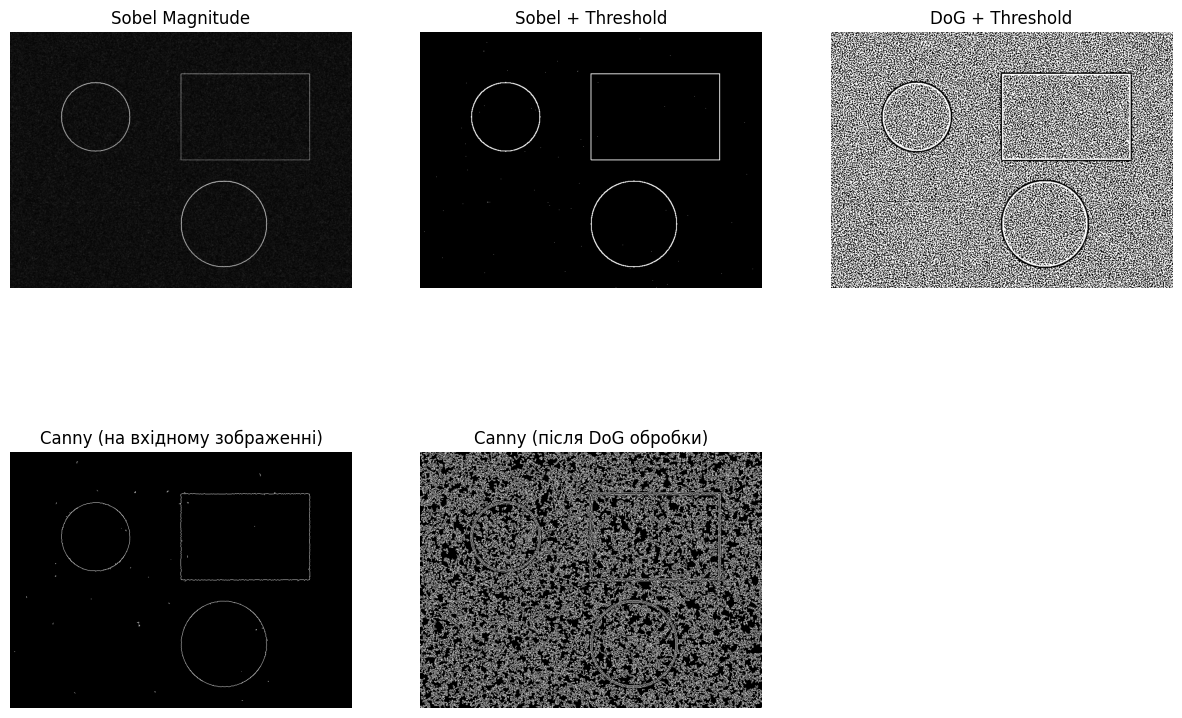

In [ ]:
# 3. Завдання 2: Виділення контурів (Sobel, DoG, Canny)
# === A. Фільтр Собеля ===
# Обчислюємо градієнти по X та Y
sobelx = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3)

# Обчислюємо магнітуду градієнта
sobel_magnitude = np.sqrt(sobelx**2 + sobely**2)
# Нормалізація до 0-255
sobel_magnitude = cv2.normalize(
    sobel_magnitude, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

# Порогова обробка результату Собеля для отримання чітких ліній
_, sobel_thresh = cv2.threshold(sobel_magnitude, 50, 255, cv2.THRESH_BINARY)


# === B. Difference of Gaussians (DoG) ===
# DoG працює як смуговий фільтр, віднімаючи одне розмите зображення від іншого
g1 = cv2.GaussianBlur(gray_image, (3, 3), 0)
g2 = cv2.GaussianBlur(gray_image, (9, 9), 0)
dog = g1.astype(np.float32) - g2.astype(np.float32)

# Нормалізація та поріг
dog_norm = cv2.normalize(dog, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
# Інвертуємо (або підбираємо поріг), щоб отримати контури
_, dog_thresh = cv2.threshold(dog_norm, 127, 255, cv2.THRESH_BINARY)


# === C. Детектор Canny (Порівняння) ===

# 1. Canny на "сирому" (вхідному) зображенні
canny_raw = cv2.Canny(gray_image, 100, 200)

# 2. Canny з попередньою обробкою (наприклад, після розмиття/фільтрації DoG)
# Використаємо результат DoG як вхід для Canny (це підсилює краї)
canny_preprocessed = cv2.Canny(dog_norm, 50, 150)

# === Відображення результатів ===
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.imshow(sobel_magnitude, cmap='gray')
plt.title("Sobel Magnitude")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(sobel_thresh, cmap='gray')
plt.title("Sobel + Threshold")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(dog_thresh, cmap='gray')
plt.title("DoG + Threshold")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(canny_raw, cmap='gray')
plt.title("Canny (на вхідному зображенні)")
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(canny_preprocessed, cmap='gray')
plt.title("Canny (після DoG обробки)")
plt.axis('off')

plt.show()

Висновки

В ході виконання другої частини роботи були досліджені методи сегментації та виділення контурів:

Порогова обробка:

Було реалізовано вставку бінаризованого зображення в зону, обмежену фігурою Ліссажу (Варіант 12), яка займає >50% площі.

Порівняння показало, що метод Отсу автоматично підбирає поріг (у нашому випадку значення otsu_thresh_val), який адаптується до гістограми зображення, мінімізуючи дисперсію всередині класів. Ручний підбір може бути ефективним, але вимагає експериментів.

Виділення контурів:

Фільтр Собеля: Добре виділяє границі, але результат ("товсті" лінії) залежить від освітлення і вимагає додаткової порогової обробки.

DoG (Difference of Gaussians): Ефективний для виділення деталей різного масштабу, працює як смуговий фільтр.

Canny: Показав найкращі результати серед розглянутих методів. Він дає тонкі (в один піксель) та неперервні контури завдяки етапам придушення немаксимумів та гістерезису.

Порівняння: Застосування Canny до зображення, попередньо обробленого фільтром DoG, дозволило виділити навіть слабкі контури, які були пропущені при обробці "сирого" зображення, проте це також збільшило кількість шумів на контурах.